In [1]:
from rubix.core.pipeline import RubixPipeline 
import os
config = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 14,
        "reuse": True,
        },
        
        "subset": {
            "use_subset": True,
            "subset_size": 1000,
        },
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-14.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE"},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1},
        
    "ssp": {
        "template": {
            "name": "BruzualCharlot2003"
        },
    },        
}

pipe = RubixPipeline(config)

data= pipe.run()

2024-05-16 13:10:45,201 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <  
/_/|_|\____/____/___/_/|_|  
                            

2024-05-16 13:10:45,202 - rubix - INFO - Rubix version: 0.0.1.post55+g93a544d
2024-05-16 13:10:45,268 - rubix - INFO - Getting rubix data...
2024-05-16 13:10:45,268 - rubix - INFO - Rubix galaxy file already exists, skipping conversion
2024-05-16 13:10:47,529 - rubix - INFO - Data loaded with 484076 particles.
2024-05-16 13:10:47,529 - rubix - DEBUG - Data Shape: {'coords': (484076, 3), 'velocities': (484076, 3), 'metallicity': (484076,), 'mass': (484076,), 'age': (484076,)}
2024-05-16 13:10:47,530 - rubix - INFO - Setting up the pipeline...
2024-05-16 13:10:47,531 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {'type': 'face-on'}}, 'spaxel_assignment': {'name': 'spaxel_assignment', 'depends_on': 'rotate_

rotating galaxy:  face-on


2024-05-16 13:10:48,240 - rubix - DEBUG - Calculation Finished! Spectra shape: (1, 484076, 842)
2024-05-16 13:10:48.882976: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 24.31GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 26102664704 bytes.

In [ ]:
import jax 
import jax.numpy as jnp
# Create a function to calculate a single IFU cube
def calculate_ifu_cube(stars_spectra, pixel_indices):
    # Create an IFU cube of shape (25*25, 842)
    #ifu_cube = jnp.zeros((25 * 25, 842))
    
    # Use jax.ops.segment_sum to sum the spectra into the IFU cube based on pixel indices
    ifu_cube = jax.ops.segment_sum(stars_spectra, pixel_indices, num_segments=25*25)
    
    # Reshape the IFU cube to the desired shape (25, 25, 842)
    ifu_cube = ifu_cube.reshape((25, 25, 842))
    
    return ifu_cube

spectra = data["spectra"]
assignments = data["pixel_assignment"]

# Calculate 4 individual IFU cubes
ifu_cubes = jax.vmap(calculate_ifu_cube)(spectra, assignments)

# Sum the 4 IFU cubes
final_ifu_cube = jnp.sum(ifu_cubes, axis=0)
final_ifu_cube.shape

(25, 25, 842)

In [ ]:
ssp = pipe.ssp
wavelengths = ssp.wavelength

# get the indices of the visible wavelengths of 4000-8000 Angstroms

visible_indices = jnp.where((wavelengths >= 4000) & (wavelengths <= 8000))



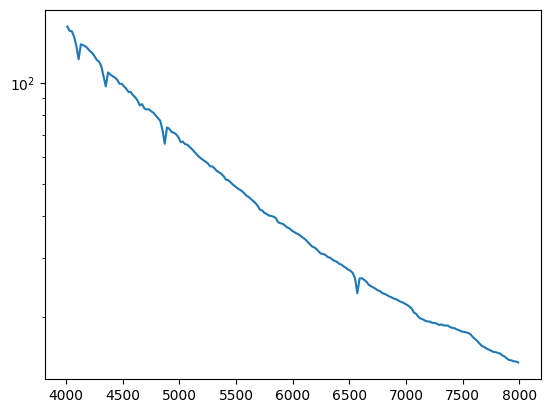

In [ ]:
# plot example spectrum
import matplotlib.pyplot as plt

spec = final_ifu_cube[12, 12]

plt.plot(wavelengths[visible_indices], spec[visible_indices])
plt.yscale("log")

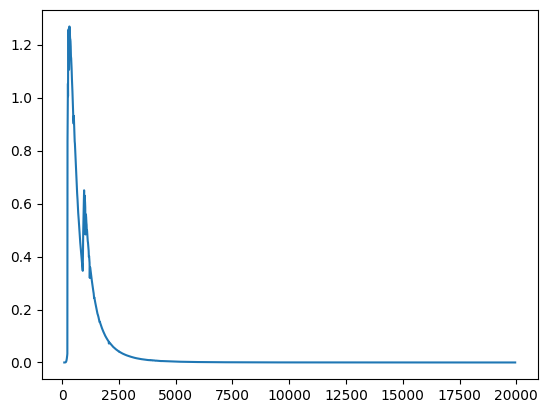

In [ ]:
plt.plot(wavelengths,ssp.flux[0,0])

In [ ]:
visible_indices[0].shape

(200,)

In [ ]:
# get the spectra of the visible wavelengths from the ifu cube
visible_spectra = final_ifu_cube[:, :, visible_indices[0]]
visible_spectra.shape

(25, 25, 200)

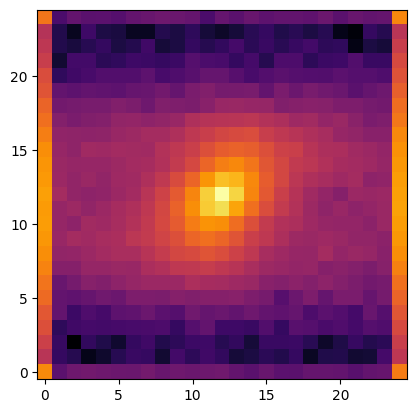

In [ ]:
# Sum up all spectra to create an image
image = jnp.sum(visible_spectra, axis = 2)
image = jnp.log10(image + 1)
plt.imshow(image, origin="lower", cmap="inferno")